# Introduction to Model Predictive Control (BYU ME 431 / ECE 483)

This intro is built on a tutorial written by Mathew Haskell, and modified by Dr. Killpack. This is meant as a simple introduction to MPC, with some practical experience with tuning the weights and understanding the effect of certain parameters assuming the following: 

* quadratic cost
* linear and discrete-time dynamics
* additional constraints on states or inputs are linear 
* we are computationally limited (so length of time horizon matters)

## MPC overview 


MPC is a form of optimal control that can include constraints on states, inputs, or functions of either (in addition to using the normal dynamics constraint to keep solutions physically meaningful or feasible). The picture below shows the main ideas that are necessary to understand MPC. 

<img src="./images/MPC.png" alt="drawing" width=50% />

The basic idea behind MPC is that an optimization problem is solved to generate a trajectory of inputs to apply to a system over a specified time horizon (aquamarine line).
These inputs are applied to an internal model in order to predict the future trajectory of states over the same time horizon (gold line) that drive the system towards its goal trajectory (red line).

Generally, only the first calculated input from the horizon is applied to the system (aquamarine line from k to k+1) and the problem is repeatedly solved at each time step (k+1 in this figure becomes k at the next time step), so there is a rolling time window or "horizon." This is why MPC is also referred to as receeding horizon control.

This allows for the benefit of feedback more frequently and can make up for some modeling errors, essentially approximating or giving the benefits of normal feedback control or LQR where we found a gain matrix. 

MPC has three main pieces:
  1. Model
  1. Time Horizon
  1. Optimization (constraints and objective)

We will take a look at each of these below. There is a table of contents menu on the left sidebar (or after you click "outline" at the top of the notebook) to quickly jump to a section. Also, you can collapse/expand a cell or group of cells by clicking the arrow next to the heading.

### Model 

As the name implies, MPC requires a model that predicts future states based on the current state and provided input.
Some algorithms use continuous dynamic models, but essentially perform numerical integration as part of the optimization. Instead, in this tutorial, we propagate the dynamics with a discrete-time model. 

A common way to get a discrete-time model is to take the continuous-time state space form of a dynamic system:

$$\dot{x}(t)=f(x(t),u(t))$$
and then discretize it:
$$x_{k+1}=f_d(x_k,u_k).$$

An example of this process for linear dynamics is shown below in the mass-spring-damper example. 

#### Linear vs Nonlinear MPC

At this point, we should distinguish between linear and nonlinear MPC. The literature on MPC is not always consistent on what the difference is between linear MPC and nonlinear MPC (NMPC). In this tutorial, we will make that distiction based on whether the model is linear or nonlinear throughout the optimization. This means if a nonlinear model is linearized in some way during the optimization over a single time horizon, we consider it linear MPC even though the system has nonlinear dynamics. 

One could call this "linearized MPC," and this is similar to LQR (*linear* quadratic regulator) where you can perform LQR on a nonlinear system by linearizing, but it is still called a *linear* control method. 

The distinction we are making in this tutorial is that we will only refer to NMPC if the optimization problem is using nonlinear dynamics to propagate the state over the time horizon. As you can imagine, using nonlinear dynamics during the optimization may give more accurate results, but requires much more computational effort and takes more time to solve. It is common in the literature to use linear MPC if you need a lot of speed. It is also a gentler introduction and is therefore the focus of this tutorial. 

#### Linearization

Linearization can be done around any solution to the system, but the simplest linearization point is an equilibrium point.

A system is in equilibrium when $\dot{x}_{eq} = f(x_{eq},u_{eq}) = 0$, meaning that the states will not change from equilibrium when the equilibrium input is applied. Linearizing equations in a general nonlinear state-space form around some equilibrium point $(x_{eq}, u_{eq})$ allows you to generate a linear state-space model with $\tilde{x}=x-x_{eq}$ and $\tilde{u}=u-u_{eq}$.

We can accomplish this using a mulitivariate Taylor series expansion (i.e. Jacobian linearization):

$\begin{array}{rcl}
\dot{x}(t) &\approx& f(x_{eq},u_{eq}) + \left.\frac{\partial f}{\partial x}\right\vert_{eq}\left(x(t)-x_{eq}\right) + \left.\frac{\partial f}{\partial u}\right\vert_{eq}\left(u(t)-u_{eq}\right) \\
\dot{\tilde{x}}(t) &=& \left.\frac{\partial f}{\partial x}\right\vert_{eq}\tilde{x}(t) + \left.\frac{\partial f}{\partial u}\right\vert_{eq}\tilde{u}(t) \\
&=& A\tilde{x}(t)+B\tilde{u}(t).
\end{array}$

This gives us the model derived earlier in chapters 4 and 6 of our textbook. 

$$\dot{\tilde{x}}(t) = A\tilde{x}(t)+B\tilde{u}(t).$$

#### Discretization

With the above model, we can perform a simple forward difference numeric integration in order to discretize it (this is an overly simple discretization method that is not used in the example below, but is used to show the general idea of discretization of a state space model). This is accomplished by assuming we can approximate $\dot{\tilde{x}}_k \approx \frac{\tilde{x}_{k+1}-\tilde{x}_k}{\Delta t}$, and then solve for $x_{k+1}$ as follows: 

\begin{align}
\frac{\tilde{x}_{k+1}-\tilde{x}_k}{\Delta t} &= A\tilde{x}_k+B\tilde{u}_k \\
\tilde{x}_{k+1} &= \tilde{x}_k + \Delta t\left(A\tilde{x}_k+B\tilde{u}_k\right) \\
&= (I+\Delta tA)\tilde{x}_k + (\Delta tB)\tilde{u}_k .
\end{align}

This gives us the discretized version:
$$
\tilde{x}_{k+1}=A_d\tilde{x}_k+B_d\tilde{u}_k.
$$

or the same equation, but expressed without tilde variables:
$$
x_{k+1}=A_d(x_k-x_{eq})+B_d(u_k-u_{eq})+x_{eq}.
$$

We could leave the discrete model in terms of the tilde variables; however, it is simpler to use the original state and input so that the reference trajectory and constraints do not have to be expressed relative to tilde variables. Also, this way the optimization solves directly for the actual inputs ($u_k$) so that the control is done without having to add the equilibrium input back to the output of our MPC. 

### Time Horizon

There are 2 pieces of information that affect how far into the future a state trajectory will be predicted: the time step ($t_s$) and the number of steps ($N$, labeled as $p$ in the image above from Wikipedia, and as $H$ in much of the literature on MPC).

The length of the horizon is then $t_s*N$. So if we look 10 steps into the future and discretize the system at 0.1s, then the length of the horizon will be $0.1*10=1s$. Both of these values in the time horizon are tuning parameters for our controller. 

#### Time Horizon Length

The effect of the length of the time horizon depends significantly on the system and the objective function defined. However, for many systems, a very small time horizon that does not initially include the system reaching steady state still works. 

The overall effect of the time horizon length is that if it is too short, our control results in a greedy behavior. For some systems this is acceptable, but if a system has significant momentum and the effect of this momentum is not predicted with enough time to react with control, the system will overshoot.
MPC with an accurate model and a long enough time horizon that sees the system reach steady state can prevent overshoot while maintaining a fast response, it is optimal after all! Shorter time horizons can be provably sub-optimal, however, they still often result in effective control (more effective than LQR and PID). 

#### Predicting Future States

One iteration of MPC requires knowledge of the current state, $x_0$, and the optimization solver will generate an input trajectory, $u_0,u_1,...,u_N$, that the model will use to predict a state trajectory, $x_1,x_2,...,x_{N+1}$.
Let's visually walk through a couple of steps.

$$
x_1 = A_d x_0 + B_d u_0.
$$

Here, $x_0$ needs to be known and provided to the optimization solver to produce $u_0$.
Now the next step:

$$
x_2 = A_d x_1 + B_d u_1.
$$

We can solve the first equation for $x_1$ and the optimization solver will use that to generate $u_1$.
You can see how this second equation could also be written entirely in terms of $x_0$ by substituting the first equation into the second:

\begin{align}
x_2 &= A_d (A_d x_0 + B_d u_0) + B_d u_1 \\
    &= A_d^2 x_0 + A_d B_d u_0 + B_d u_1.
\end{align}

Now let's solve for $x_3$:

$$
x_3 = A_d x_2 + B_d u_2.
$$

Let's do a similar substitution as before:

\begin{align}
x_3 &= A_d (A_d^2 x_0 + A_d B_d u_0 + B_d u_1) + B_d u_2 \\
    &= A_d^3 x_0 + A_d^2 B_d u_0 + A_d B_d u_1 + B_d u_2.
\end{align}

Continuing this pattern we can solve for $x_n$ in terms of only $x_0$, $A_d$, $B_d$, and the inputs.

$$
x_N = A_d^N x_0 + \sum_{j=0}^{N-1} A_d^{N-1-j} B_d u_j.
$$

We know $x_0$, $A_d$, and $B_d$ (which are constant over the horizon because it is an LTI model).
So the only real unknowns are all of the inputs in the trajectory, which are used to solve for future states (the future state trajectory can be an optimization variable or it can be hidden internally in the optimization, which is the difference between what is formally the intrinsic and extrinsic optimzation formulation (explained in more depth at the end of this notebook). The biggest takeaway for now is that the optimization only needs to know the current state $x_0$ and the commanded reference trajectory in order to generate an optimal input trajectory.

### Optimization
To this point, we have talked about how the optimization solver generates a trajectory of inputs to produce a desirable trajectory of outputs. Let's take a look at how the optimization does that. There are 3 main pieces to the optimization problem: the cost function, constraints, and parameters.

#### Cost Function

As with any optimization problem (and similar to LQR), we need to come up with a function to minimize.
This function can have several names, such as objective function or loss function.
With MPC, it is usually referred to as the cost function.
In general with controls, we want to minimize error.
Error is defined as the difference in our desired state and current state.

As the focus of this tutorial is an easy-to-solve MPC problem, and in order to have a global minimum, we want the cost function to be quadratic.
For scalars, a quadratic function is $f(x)=\alpha x^2$ where $\alpha$ is positive.
For vectors, a quadratic function looks like $f(\mathbf{x})=\mathbf{x}^TQ\mathbf{x}$ where Q is a semi-positive definite matrix (but non-zero).
Q is generally a diagonal matrix of scalar weights for each state.

Therefore, here is a basic cost function that would minimize the error in states:

$$
J_x = \sum_{k=1}^{N+1} (x_k - x_{des,k})^T Q (x_k - x_{des,k}).
$$

The cost function can really be any function of states and inputs.
Sometimes, one might want to minimize the amount of energy used by the system (e.g. prolong battery life or reduce an excess of force or torque). This can be done by adding a quadratic cost on the inputs:

$$
J_u=\sum_{k=0}^{N} u_k^T R u_k.
$$

If your inputs were motor commands to keep a multirotor vehicle in the air, you might want to add a cost on the difference in applied inputs and equilibrium inputs:

$$
J_u=\sum_{k=0}^{N} (u_k - u_{eq})^T R (u_k - u_{eq}).
$$

Another common idea is to have conservative inputs that do not change very fast (I.E. not bang-bang control).
This can be accomplished by adding a cost to the change in inputs from step to step:

$$
J_u=\sum_{k=0}^{N-1} (u_{k+1} - u_k)^T R (u_{k+1} - u_k).
$$


#### Constraints

If all we had was a cost function with no constraints, the optimization would basically tell you that you could "just teleport to the state where you want to go."
Unfortunately, for any real system, we are constrained by the time and inputs it takes to move between one state and another. Our optimization therefore needs a constraint to describe how our system is capable of moving.
The most important constraint, then, is the model that we came up with for the dynamic system:

$$
x_{k+1} = A_d x_k + B_d u_k \quad \forall k \in 0,1,...,N.
$$

So what are some other constraints/costs we might want to use?

We already saw one example in our discussion on cost functions: don't let inputs change very much from step to step. Although we used this as an example cost, we can also explicitly limit the change in inputs from step to step as follows:

$$
-\Delta u_{max} \le u_{k+1} - u_k \le \Delta u_{max}.
$$

You should now be able to see that some outcomes we want can be achieved as either a constraint or a cost, depending on how strictly we want to accomplish that outcome. And if we ever violate a constraint, a common practice is to push constraints to a term in our cost function until our system is feasible again (however, this sometimes means we are using a constraint where we should not - since it can be violated). 

Another common constraint is the saturation limits for states and inputs. Perhaps a state is a robot arm joint angle that can only move between a specific range of angles. Or maybe you have an input of thrust from a propellor that has a physical max and can't be negative.

These saturation limits can be provided to the optimization solver so that it theoretically knows how to provide optimal inputs that are dynamically achievable.

Here is what the saturation constraints would look like:

$$x_{min} \le x_k \le x_{max}$$

$$u_{min} \le u_k \le u_{max}$$

Despite only listing a few constraints, it should be clear that any constraint can be included as long as it is a function of states and inputs. In order to make a tractable optimization for MPC, these funtions will most often be linear. 

#### Parameters

Parmeters required by our MPC optimization are fairly straightforward. They are values we provide to the optimization solver that stay constant for the solution found at a single instant in time (but calculating cost by propagating our model forward over the given time horizon). After the first input is applied, the optimization will be solved again and can/will have new values for the parameters.

Examples are $A,B,N,x_0,x_{min},x_{max},u_{min},u_{max},$ and any others you might have specified in your cost function or constraints.

$x_0$ is a value that will change almost every time, because the previous input you apply will likely cause you to move. If you are linearizing a nonlinear model then $A$ and $B$ can be updated at each time step as well, but they stay fixed for a single optimization with linear MPC.


## Mass-Spring-Damper Example

Below we show the necessary steps and example code to set up an MPC problem and solve it in the control loop. The focus here is not making this optimization super time-efficient, but instead in demonstrating functionality and output from a model predictive controller. 


### Analytical Model

The governing dynamic equations are the following: 

$$m\ddot{z}+b\dot{z}+kz=f$$

The equilibrium point is:

$$f_{eq}=kz_{eq}.$$

Notice how the equilibrium force depends on the location of the mass. We don't have to worry too much about this in this example, because it is already a linear system, meaning we can linearize about any point and still model the system perfectly. Let us choose to use $z_{eq}=f_{eq}=0$ and not worry about these values to keep our example simple.

Next we generate the state-variable form:

\begin{align}
\frac{dz}{dt}  &= \dot{z} \\
\frac{d\dot{z}}{dt} &= -\frac{b}{m}\dot{z} - \frac{k}{m}z + \frac{1}{m}f
\end{align}

Let $\mathbf{x}=[z, \dot{z}]^T$ and $u=[f]$, then the state-space form is the following:

$$
\mathbf{\dot{x}} = 
\begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & -\frac{b}{m} \end{bmatrix}
\mathbf{x} +
\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u
$$

### Problem Setup

For the code example shown below for the mass-spring-damper system, we will minimize tracking error as well as minimize the inputs directly. The formal optimization problem can thus be written as such:

\begin{align}
\min_{u_k} \quad& J = \sum_{k=0}^N \left\lVert x_{k+1} - x_{des} \right\rVert_Q^2  + \left\lVert u_k \right\rVert_R^2 \\
\text{subject to:} \nonumber \\
 \quad& x_{k+1} = A_d x_k + B_d u_k \\
& u_{min} \leq u_k \leq u_{max}
\end{align}

### Code

For the example below, we recommend you run all cells first, then play with the values for $Q$ and $R$ in the last cell. However, you may obviously examine other cells and change variables like $N$ (which is the length of the time horizon). 

In [17]:
# install needed modules that aren't always installed by default
!pip3 install control
!pip3 install cvxpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [18]:
# import needed modules
import numpy as np
import control as ctrl
import cvxpy as cp
import matplotlib.pyplot as plt
from time import time as now

In [19]:
class MassSpringDamper:
  def __init__(self, m, k, b, ts):
    '''
    m: mass, k: spring constant, b: damping coefficient
    ts: discretization time step
    '''
    # continuous model
    A = np.array([[0,1],[-k/m,-b/m]])
    B = np.array([[0],[1/m]])
    C = np.eye(2)
    D = np.zeros((C.shape[0],1))

    # define a continuous-time system using the state-space representation
    sys = ctrl.ss(A,B,C,D)

    # discretize model and extract A_d and B_d
    sys_d = ctrl.c2d(sys, ts)
    self.Ad = np.array(sys_d.A)
    self.Bd = np.array(sys_d.B)

  def propagate_dynamics(self, current_state, input):
    # with a linear system you can integrate using the discretized matrices
    # for a nonlinear system you would probably do RK4 integration
    next_state = self.Ad @ current_state + self.Bd @ input
    return next_state


In [20]:
import cvxpy as cp
# This MPC class is very specific to cvxpy, which is quite slow :/
# Howevver, it is a good example of how to set up an MPC problem
# and should be easy see the terms and to adapt to other solvers. 

class MPC:
  def __init__(self, Ad, Bd, x_lin, u_lin, x_des, N, Q, R):
    '''
    Ad and Bd: discretized state-space model
    x_lin and u_lin: state and input to linearize about
    x_des: desired/goal state
    N: num steps in horizon
    Q: state weights, R: input weights -> both must be 2D numpy arrays
    '''
    n,m = Bd.shape  # defining # of states (n) and inputs (m)
    self.x = cp.Variable((n, N+1)) # add 1 for x0
    self.u = cp.Variable((m, N))
    self.x0 = cp.Parameter(n)
    cost = 0
    constr = [self.x[:,0] == self.x0] # don't allow optimization to change x0
    u_limit = np.array([0,3])

    # looping over each step in the time horizon from k=0 to N-1 
    for k in range(N):
      cost += cp.quad_form(self.x[:,k+1]-x_des, Q) # cost on error in states
      cost += cp.quad_form(self.u[:,k], R) # cost on input
      constr += [self.u[:,k] >= u_limit[0], self.u[:,k] <=u_limit[1]] # saturate inputs

      # add model as dynamics constraint
      x_tilde = self.x[:,k] - x_lin
      u_tilde = self.u[:,k] - u_lin
      constr += [self.x[:,k+1] == Ad @ x_tilde + Bd @ u_tilde + x_lin]
      
    self.problem = cp.Problem(cp.Minimize(cost), constr)
  
  def calc_next_u(self, xk):
    self.x0.value = xk # set x0 to be current state
    self.problem.solve(warm_start=True) # solve optimization
    return self.u[:,0].value # return first input from trajectory

In [21]:
def plot_results(time, pos, inputs, x_des):
  px = 1/plt.rcParams['figure.dpi']  # pixel in inches
  plt.rcParams['figure.figsize'] = (1000*px, 400*px)
  plt.close('all')
  tf = time[-1]

  fig, ax = plt.subplots(1,2)
  ax[0].plot(time, pos, 'b', label='x')
  ax[0].plot([0,tf],[1,1]*x_des.item(0), 'r--', label='$x_{des}$')
  ax[0].set_xlabel('Time (s)')
  ax[0].set_ylabel('Position (m)')
  ax[0].set_title('Mass Spring Damper Simulation')
  ax[0].legend(loc='lower right')

  ax[1].plot(time[1:], inputs, 'g', label='u')
  ax[1].plot([0,tf],[0,0], 'c:', label='$u_{min}$')
  ax[1].plot([0,tf],[3,3], color='orange', linestyle=':', label='$u_{max}$')
  ax[1].set_xlabel('Time (s)')
  ax[1].set_ylabel('Force (N)')
  ax[1].set_title('Inputs')
  ax[1].legend()

  plt.show()

In [22]:
def run_sim(Q, R):
  ## initial condition and goal
  x = np.array([0,0])
  x_des = np.array([1,0])

  ## simulation parameters
  tf = 10
  t = 0

  ## plotting variables
  pos = [x[0]]
  inputs = []
  time = [t]

  ## simulated system
  m,k,b = 5.0, 3.0, 0.5
  ts = 0.05
  system = MassSpringDamper(m, k, b, ts)

  ## set up controller
  Ad, Bd = system.Ad, system.Bd # assuming perfect model
  x_lin = np.zeros(2) # linearize about origin
  u_lin = np.zeros(1)

  N = 10 # steps in horizon
  controller = MPC(Ad, Bd, x_lin, u_lin, x_des, N, Q, R)

  ## simulate
  begin = now()
  while t <= tf:
    optimal_u = controller.calc_next_u(x)
    inputs.append(optimal_u)
      
    x = system.propagate_dynamics(x, optimal_u)
    pos.append(x[0])
      
    t += ts
    time.append(t)

  end = now()
  print('elapsed time:\t', end-begin)
  print('final position:\t', x[0])
  print('final input:\t', optimal_u[0])

  plot_results(time, pos, inputs, x_des)

elapsed time:	 0.5383687019348145
final position:	 0.0035750797356919593
final input:	 0.012105919295620986


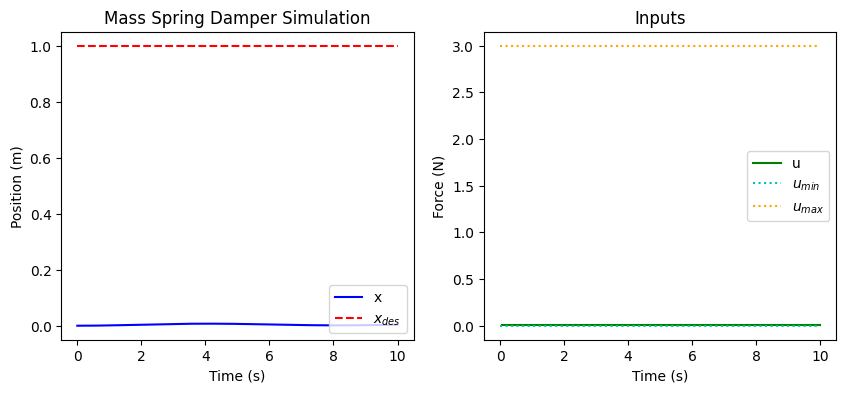

In [23]:
import numpy as np
import control as ctrl
# choose your own gains
position_weight = 0
velocity_weight = 0
force_weight = 0

# Don't change this code
Q = np.diag([position_weight, velocity_weight])
R = np.diag([force_weight])
run_sim(Q, R)

## Bonus Material About Formulating and Solving MPC 

### Explicit vs Implicit Optimization for MPC

Traditionally, MPC uses both the states and inputs over the time horizon as optimization variables with the discrete-time model constraining the relationship between them, which is implicit MPC.
Another option is to have the states be internal variables to the optimization or not even use them at all.
It turns out that the dynamics constraint can be implicitly included in the cost function.
This is because of the recursive nature of state-space models - only the initial state and trajectory of inputs are needed to calculate the future trajectory of states as we saw earlier:
$$
x_N = A^N x_0 + \sum_{j=0}^{N-1} A^{N-1-j} B u_j.
$$

So we could write a single function $g$ that takes in the current state and all of the inputs over the horizon and output a vector of the entire horizon of states concatenated together, which changes the cost function to this:
$$
J_x = \left\lVert g(x_0, u_0, \cdots, u_N) - x_{ref} \right\rVert_Q.
$$

Phil Hyatt did some experimentation with this and found the implicit formulation of MPC to solve faster.
If you saw his paper he referred to it as SmallMatrix (implicit) vs LargeMatrix (explicit) MPC.
This was related to him converting to a QP optimization problem in order to use the OSQP solver (which is really fast and I would recommend it - it's what I currently use) because the different conversions created a small and large cost matrix.


### Parameterized Inputs for MPC (to reduce size of optimization)

In general with optimization, the more design variables there are the longer it takes to solve the problem.
In ME 575, Dr. Ning mentioned that around 30 is considered a large optimization problem (if I remember correctly).

Now consider the system you want to work with.
I have dealt with quadcopters using 9 states and 4 inputs.
Even with a horizon of 10 steps, this leads to $90 + 40 = 130$ design variables.
Using implicit MPC cuts out the 90, which might be why it solves faster, but there are still 40 design variables left for this small horizon.

I have recently been using a horizon of 100 steps, which would be 400 design variables using implicit MPC; however, this input space can be parameterized to significantly reduce the search space and solve time.
This trick again came from Phil Hyatt's PhD work: he let the optimization choose 3 sets of inputs (one at the beginning, middle, and end of the horizon) and then linearly interpolated between these for the rest of the inputs in the trajectory.
Now there are only $4*3 = 12$ design variables, which is a much smaller search space.
You can use more than 3 sets of inputs; around 4-5 was shown to basically have the same performance as not parameterizing, but Phil used 3 the most.

This also implicitly adds a slew rate constraint to some degree, which is often beneficial for smooth trajectories that tend to be a little more conservative.
Initially, this might seem like a bad idea because it seems like the optimization has little freedom; however, Phil showed that there was almost an insignificant reduction of overall performance with the controller.
A key piece to understand is that the first input is unconstrained (the input to apply now) and is unaffected from the previous optimization, so the system is free to move however it wants if the first input is only ever applied before optimizing again.

One thing to note is that the parameterization is still discretly sampled, meaning that the input signal is not actually continuous.
I believe Phil tried more complicated parameterizations than linear interpolation but did not find significant improvement from them and decided that the extra complexity wasn't worth the effort.